# Maximum Likelihood Neural Regression

In [1]:
#Modulees

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

import pandas as pd

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import neural_regression

#jaxgeometry
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-10 23:05:53.265053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
score_path = "scores"
s2_approx = 0
s1loss_type = "dsmvr"
s2loss_type = "dsmvr"
s2_type = "s1s2"
seed = 2712

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def load_mlnr_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    layers_s1, layers_s2 = layers
    mlnr_path = f"mlnr/{manifold}{dim}/"
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    @hk.transform
    def mlnr_model(x):
        
        mlnr =  neural_regression.MLP_mlnr(
            neural_regression.MLP_f(dim=generator_dim, layers=layers_s1), 
            neural_regression.MLP_sigma(layers=layers_s1)
            )
         
        return mlnr(x)
    
    rng_key = jrandom.PRNGKey(seed)
    mlnr_state = model_loader.load_model(mlnr_path)
    
    mlnr_fun = lambda x: mlnr_model.apply(mlnr_state.params, rng_key, x)
                       
    return M, x0, mlnr_fun

In [4]:
def load_data(manifold, dim):
    mlnr_path = f"mlnr/{manifold}{dim}/"
    input_data = pd.read_csv(''.join((mlnr_path, 'input.csv')), header=None)
    output_data = pd.read_csv(''.join((mlnr_path, 'output.csv')), header=None)
    
    return jnp.array(input_data.values), jnp.array(output_data.values)

## Testing with $\mathbb{R}^{2}$

In [5]:
M, x0, mlnr_fun = load_mlnr_model("Euclidean", 2)
input_data, output_data = load_data("Euclidean", 2)

using M.Exp for Logarithm


In [6]:
sorted_input = jnp.sort(input_data, axis=0)
f, sigma = mlnr_fun(sorted_input)

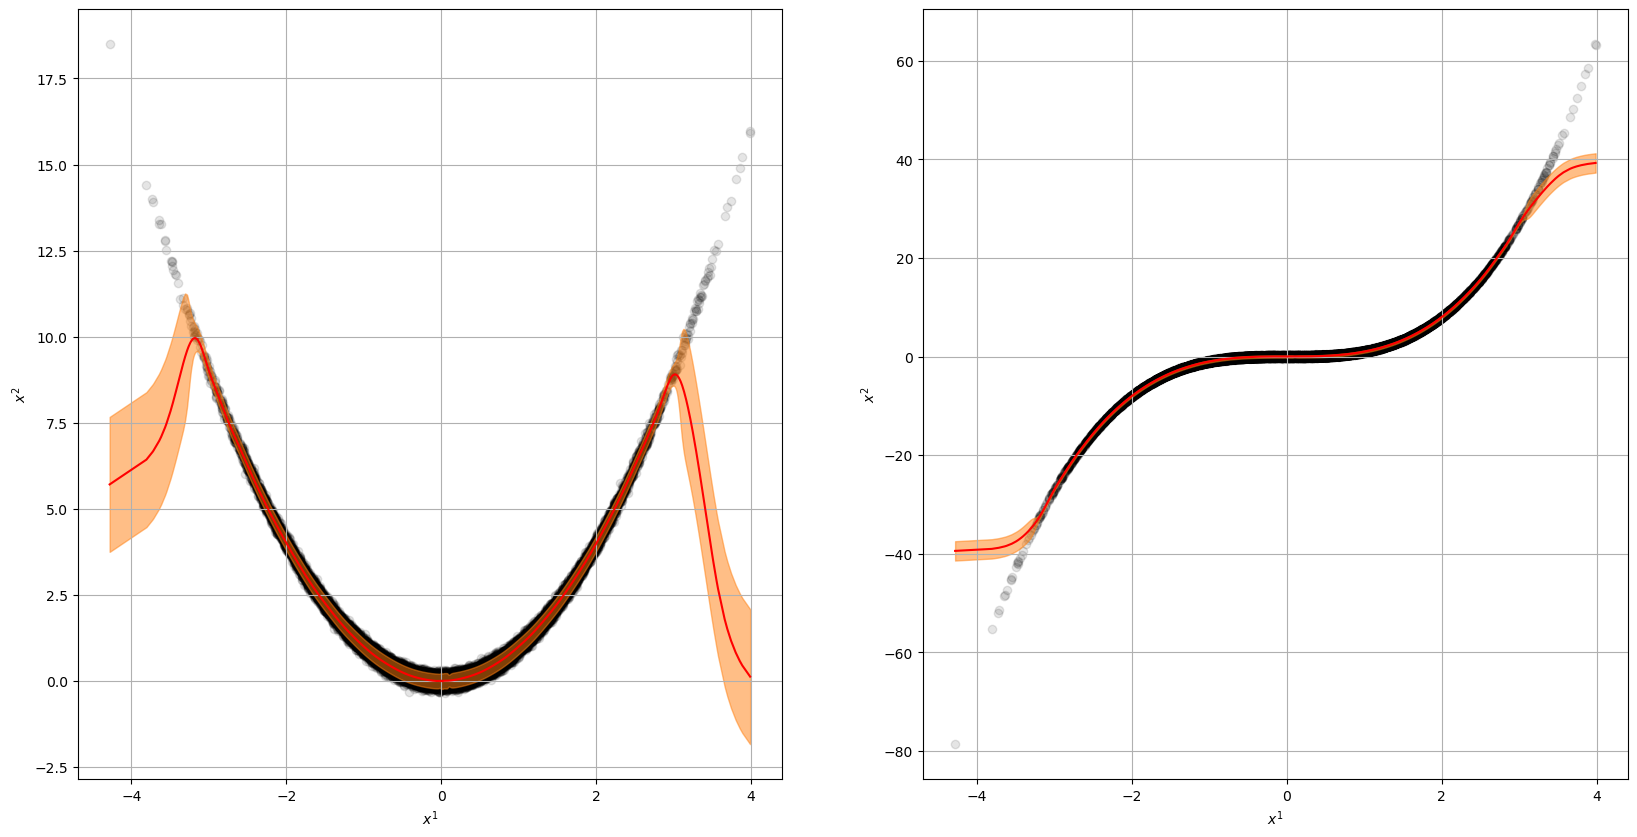

In [8]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(sorted_input, f[:,0], color='red')
ax.scatter(input_data,output_data[:,0], color='black', alpha=0.1)
ax.fill_between(
    sorted_input.ravel(),
    f[:,0] - 1.96 * sigma,
    f[:,0] + 1.96 * sigma,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

ax = fig.add_subplot(122)
ax.plot(sorted_input, f[:,1], color='red')
ax.scatter(input_data,output_data[:,1], color='black', alpha=0.1)
ax.fill_between(
    sorted_input.ravel(),
    f[:,1] - 1.96 * sigma,
    f[:,1] + 1.96 * sigma,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

plt.show()
